# Executive summary

1. Objective: Develop a model to predict whether a book review is positive.

2. Logistic Regression appears to be the most stable model when using input data provided by a TFIDF vectorizer.

3. An F1 score of 0.94 and 0.86 AUC score was achieved on the test dataset.

4. Despite this, deeper analysis indicates the model still underperforms. Alternative strategies may be required.


NOTE: 
* I've reused some parts of Unsupervised Algorithms Final Project.
* The detailed code mechanism is presented under Report - real summary.

# Plan

1. Dataset description
2. Cleaning dataset
3. Dataset stats
4. Vocab analysis
5. Ngram analysis
6. Other features
7. TFiDF launch
9. Hyperparameter search - phase I
10. Hyperparameter search - phase II
11. Final model stats
12. Conclusion

# Libraries

In [1]:
!pwd

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/notebooks


In [2]:
# Libraries

from pandarallel import pandarallel
import sys
import nltk
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import sys
sys.path.append("..")

from flashtext import KeywordProcessor
from constant import MAPPING_OVERALL_TO_SENTIMENT, MAPPING_SENTIMENT_TO_NUMBER
from sklearn.metrics import f1_score
nltk.download("wordnet")
from data_preprocessors.data_cleaner import DataCleaner
from data_preprocessors.spacy_analyzer import SpacyAnalyzer
from data_preprocessors.correction_heuristics_executor import (
    CorrectionHeuristicsExecutor,
)
from pandarallel import pandarallel
import numpy as np
import pandas as pd
import re
from dataclasses import dataclass
from tqdm import tqdm
from glob import glob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

pandarallel.initialize(progress_bar=True, nb_workers=10)

[nltk_data] Downloading package wordnet to /home/artur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /home/artur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_28436/1209668928.py:58: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# About dataset

Source: [Kaggle - Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews)

This dataset contains approximately 3 million book reviews for 212,404 unique books, along with user information for each review. However I used only 140000 rows to conduct the Exploratory Data Analysis (EDA). Let's delve deeply into the data!

In [3]:
# !rm -R ../data
!mkdir -p  ../data

In [6]:

train_data = pd.read_csv(
    "../data/Books_rating.csv",
    names=[
        "asin",
        "title",
        "price",
        "userId",
        "profileName",
        "reviewHelpfulness",
        "overall",
        "reviewTime",
        "reviewSummary",
        "reviewText",
    ],
)

/tmp/ipykernel_28436/1334125578.py:1: DtypeWarning: Columns (2,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(


In [7]:
train_data = train_data.head(140000)

In [8]:
train_data

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText
0,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
2,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
3,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
4,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
...,...,...,...,...,...,...,...,...,...,...
139995,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A26ZAM8KFU0GY9,Jim Estill,0/2,4.0,1155081600,How to Thrive,I read Collapse by Jared Diamond. This is an a...
139996,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A3KKUNIFVEAHNC,saskatoonguy,7/14,2.0,1143244800,Intriguing bits of world history plus sky-is-f...,Most of this book consists of stories of faile...
139997,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ALF72BQ4RIEL,Bill Pen Name,4/9,5.0,1137024000,A Must Read for all Thoughtful People,This work would rate at the top of the scale j...
139998,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ZS0YNUQ4UAJ2,Susan Norton,4/9,5.0,1107561600,Full of interest,I'm not sure if I agree with everything in thi...


# Cleaning training data

In order to get cleaner text (without typos and unknown words), I have:
- removed duplicated punctuations,
- converted emojis to the word equivalents (e.g. kiss mark),
- removed unknown words from pov of wordnet, 
- removed characters that occur more than 2 times consequtively, 
- converted compound words that are mistakenly written into separate words
etc. 


In [9]:
!rm -R train_spans # clean up resources

rm: cannot remove 'train_spans': No such file or directory


The dataset contains initially 140000 rows. Let's collect infos about lemmas, part of sequence taggings. For this exercise I used SpacyAnalyzer processor, as well as custom CorrectionHeuristicsExecutor. This entire sequence is about reducing effect of typos and misclicks on the quality of the data (I used i.a. Viterbi algorithm).

In [11]:
data_cleaner = DataCleaner(train_data)
data_cleaner.preprocess()
data_cleaner.data = data_cleaner.data[
    ~(data_cleaner.data.reviewText == "")
].reset_index(drop=True)

08-15 14:05 data_preprocessors.data_cleaner INFO     Words that are uppercase are converted to lowercase


08-15 14:06 data_preprocessors.data_cleaner INFO     Contraction converted to two words sequences


08-15 14:06 data_preprocessors.data_cleaner INFO     HTML characters dropped


08-15 14:06 data_preprocessors.data_cleaner INFO     Emojis dropped


08-15 14:06 data_preprocessors.data_cleaner INFO     Duplicate punctuation removed


08-15 14:06 data_preprocessors.data_cleaner INFO     Removed more than 3 consecutive same characters


08-15 14:06 data_preprocessors.data_cleaner INFO     Add space after punctuation


08-15 14:06 data_preprocessors.data_cleaner INFO     Duplicate spaces removed
08-15 14:06 data_preprocessors.data_cleaner INFO     Cleaning process ended


In [12]:
data_cleaner.data.to_csv("../data//_train_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_train_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="train_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

08-15 14:06 data_preprocessors.spacy_analyzer INFO     Spacy analysis started
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:09<00:00, 85.94s/it]
08-15 14:13 data_preprocessors.spacy_analyzer INFO     Spacy analysis ended
/tmp/ipykernel_28436/1394957835.py:13: DtypeWarning: Columns (3,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
08-15 14:14 data_preprocessors.correction_heuristics_executor INFO     Words will be corrected into known words or removed
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140000/140000 [00:25<00:00, 5489.95it/s]
08-15 14:14 data_preprocessors.correction_heuristics_executor INFO     Pipeline ended


In [13]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

  0%|          | 0/140000 [00:00<?, ?it/s]

In [14]:
data["cleaned sentences"] = texts

In [15]:
len(new_texts)

140000

In [16]:
data.shape

(140000, 11)

In [17]:
data["text_lematized"] = new_texts

In [18]:
data["length"] = train_data.reviewText.str.len()

In [19]:
# removing 30000 outliers
data = data[np.logical_and(data["length"] < 2500, data["length"] > 100)]

In [20]:
data.reset_index(drop=True).to_csv("../data/final_train_data.csv")

In [21]:
train_data.groupby("title").size().sort_values(ascending=False)

title
The Hobbitt, or there and back again; illustrated by the author.                                                           4420
Fahrenheit 451                                                                                                             3287
ERAGON: INHERITANCE, BOOK ONE.                                                                                             3137
1984                                                                                                                       1895
Great Expectations                                                                                                         1643
                                                                                                                           ... 
Nudes                                                                                                                         1
Nurturing Change through Your Human Assets: Optimising Organisational Challenges in the New Millen

# Short overview

Cleaned data contains unique 124601 reviews  on 15103 books. Some of them are spams, some laconic, some are examples of the very good piece of writing. 

In [26]:
train_data = pd.read_csv("../data/final_train_data.csv")

In [27]:
len(train_data.reviewText.unique())

119791

In [28]:
len(train_data.title.unique())

9008

In [29]:
print(
    train_data[
        train_data.reviewText.str.len() == train_data.reviewText.str.len().max()
    ].reviewText.values[0][:1000]
)

Forget Alvin Schwartz! The stories in these books are merely collected from folklore. they are nothing but old campfire tales. They are told in a very basic format that did not invoke any feelings of fear in my little 12 year old mind back in good old ' 92. Hey, i even think there was some sort of appendix in the back that provided more real- world explainations of some of the stories or where the old folklore came from. h. p. Lovecraft said that the greatest fear is fear of the unknown. I will say that the stories alone would have given these books maybe three stars. It' s the pictures. They are so beautifully crafted and surreal. You cannot quite make out the details, yet at the same time, everything that is rotten or dilapidated stands out right away. i have never seen the style anywhere else, not in any art book, not in any museum, not in any history book, nothing! Stephen Gammell is truly an artist. i do not care about all those artists that slap a bunch of shapes together and the

In [30]:
try:
    print(train_data[train_data.reviewText.str.len() < 100].reviewText.values[0][:1000])
except:
    pass

In [31]:
train_data["sentiment"] = train_data["overall"].apply(
    lambda x: MAPPING_OVERALL_TO_SENTIMENT[x]
)

08-15 14:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
08-15 14:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
08-15 14:25 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
08-15 14:25 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
08-15 14:25 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', st

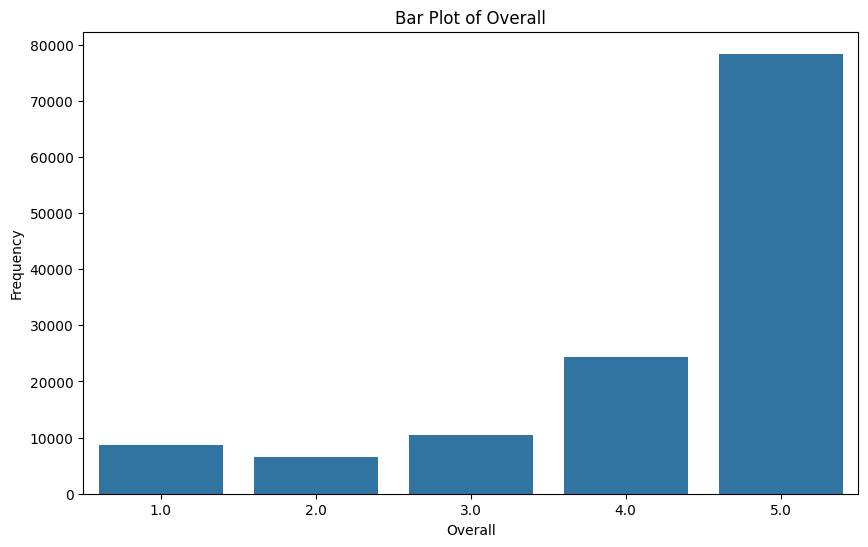

In [32]:
plt.figure(figsize=(10, 6))
ordered_overall = sorted(train_data["overall"].fillna(3.0).unique())
sns.countplot(x="overall", data=train_data, order=ordered_overall)

plt.title("Bar Plot of Overall")
plt.xlabel("Overall")
plt.ylabel("Frequency")
plt.show()

# Vocab analysis

Analysis of vocabulary from a part of speech perspective might be useful, especially if we would like to examine how the text of a typical review is constructed.

In [33]:
analyzer = SpacyAnalyzer(
    path_to_data="../data/final_train_data.csv",
    chunk_size=30000,
    destination_folder="../train_spans/",
)
poses = analyzer.collect_info_about_words("pos")

In [34]:
counted_poses = [
    Counter([word[1] for sentence in sequence for word in sentence])
    for sequence in poses
]

counted_poses = [dict(count) for count in counted_poses]


poses_matrix = pd.DataFrame(counted_poses)

poses_matrix["NOUN"].plot.hist()

KeyError: 'NOUN'

In [ ]:
noun_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "NOUN"
]
verb_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "VERB"
]
adjective_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "ADJ"
]

In [ ]:
noun_occurences = Counter(noun_occurences)

In [35]:
results = sorted(dict(noun_occurences), key=lambda x: noun_occurences[x], reverse=True)
{key: noun_occurences[key] for key in results[:30]}

NameError: name 'noun_occurences' is not defined

In [36]:
verb_occurences = Counter(verb_occurences)

NameError: name 'Counter' is not defined

In [37]:
results = sorted(dict(verb_occurences), key=lambda x: verb_occurences[x], reverse=True)
{key: verb_occurences[key] for key in results[:30]}

NameError: name 'verb_occurences' is not defined

In [38]:
adjective_occurences = Counter(adjective_occurences)

NameError: name 'Counter' is not defined

In [39]:
results = sorted(
    dict(adjective_occurences), key=lambda x: adjective_occurences[x], reverse=True
)
selected_results = {key: adjective_occurences[key] for key in results[:50]}

NameError: name 'adjective_occurences' is not defined

In [40]:
selected_results

NameError: name 'selected_results' is not defined

Definitely, some words should be removed because they do not indicate any specific topic and could reduce the effectiveness of the TF-IDF vectorizer.

# Vocabulary analysis per ngram and sentiment type. 

Let's analyse corpus for mixed, negative and positive reviews from this perspective.

## Positive ngrams

In [41]:
@dataclass
class VectorizerData:
    ngram: int
    sentiment: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [42]:
with open("stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

In [43]:
def get_top_ngram(sentiment, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    bag_of_words = vectorizer.fit_transform(
        train_data[train_data.sentiment == sentiment]["reviewText"]
    )
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return VectorizerData(
        ngram=n,
        sentiment=sentiment,
        vectorizer=vectorizer,
        sum_words=sum_words,
        words_freq=words_freq,
    )

In [44]:
positive_1_gram = get_top_ngram("positive", 1)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

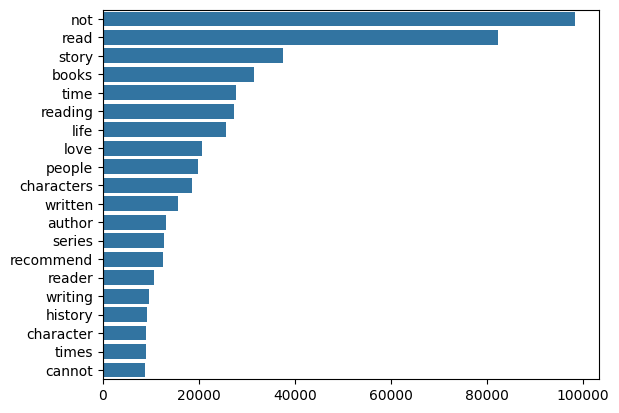

In [45]:
x, y = map(list, zip(*positive_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [46]:
positive_2_gram = get_top_ngram("positive", 2)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

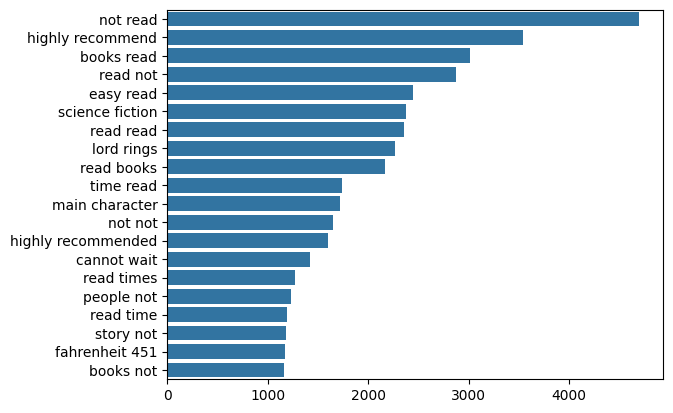

In [47]:
x, y = map(list, zip(*positive_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [48]:
positive_3_gram = get_top_ngram("positive", 3)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

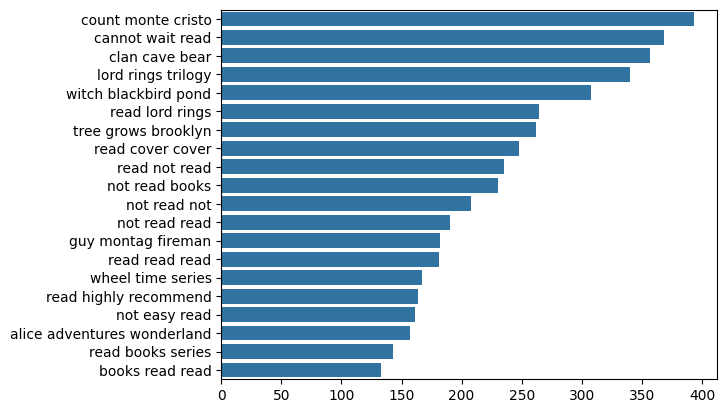

In [49]:
x, y = map(list, zip(*positive_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Negative ngrams

In [50]:
negative_1_gram = get_top_ngram("negative", 1)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

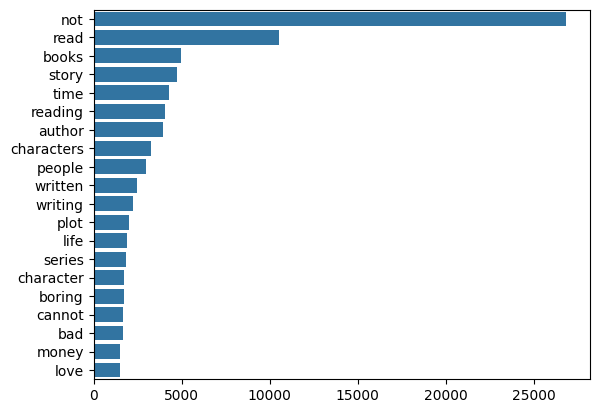

In [51]:
x, y = map(list, zip(*negative_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [52]:
negative_2_gram = get_top_ngram("negative", 2)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

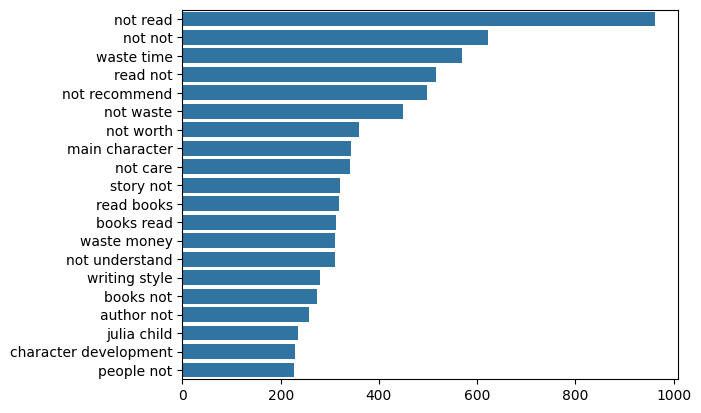

In [53]:
x, y = map(list, zip(*negative_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [54]:
negative_3_gram = get_top_ngram("negative", 3)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

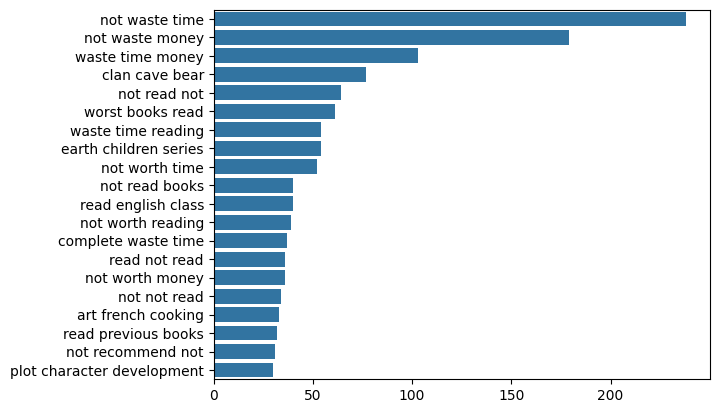

In [55]:
x, y = map(list, zip(*negative_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Mixed ngrams

In [56]:
mixed_1_gram = get_top_ngram("mixed", 1)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

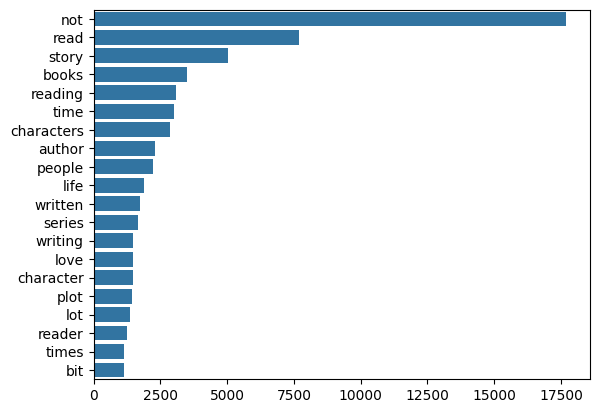

In [57]:
x, y = map(list, zip(*mixed_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [58]:
mixed_2_gram = get_top_ngram("mixed", 2)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

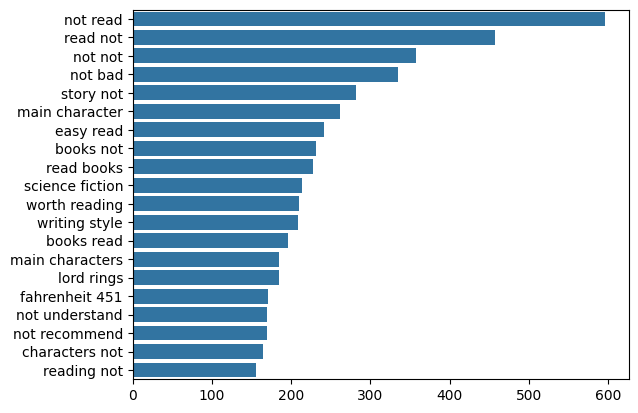

In [59]:
x, y = map(list, zip(*mixed_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [60]:
mixed_3_gram = get_top_ngram("mixed", 3)

/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

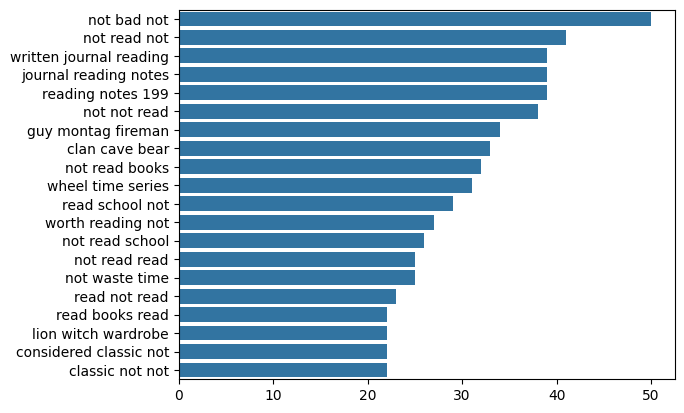

In [61]:
x, y = map(list, zip(*mixed_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

Mixed reviews (3.0) will be removed because they cannot be classified as either positive or negative.

# Other features

In [62]:
train_data["total_length"] = train_data["reviewText"].apply(lambda x: len(x))
train_data["num_exclamation_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("!")
)
train_data["num_question_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("?")
)
train_data["num_punctuation"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in ".,;:")
)
train_data["num_symbols"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in "*&$%")
)

In [63]:
train_data["mapped_sentiment"] = train_data["sentiment"].apply(
    lambda x: MAPPING_SENTIMENT_TO_NUMBER[x]
)

In [64]:
corr = train_data[train_data["sentiment"].isin(["positive", "negative"])][
    [
        "total_length",
        "num_exclamation_marks",
        "num_question_marks",
        "num_punctuation",
        "num_symbols",
        "mapped_sentiment",
    ]
].corr()

08-15 14:29 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x713b9fa3c610>


<Axes: >

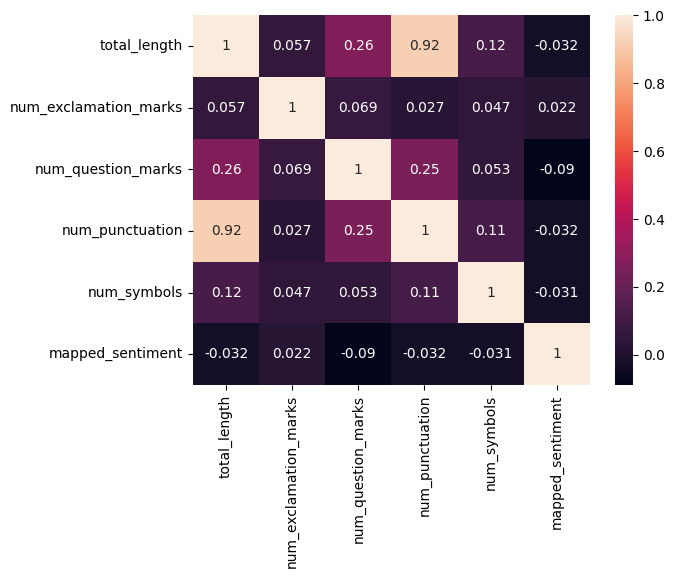

In [65]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

We can see that these features are not correlated with the mapped sentiment, which means we can remove them from the analysis.

Source of idea: https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

# Lengths

Most of the reviews are between 0 and 500 characters length.

In [66]:
lengths = train_data.reviewText.apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

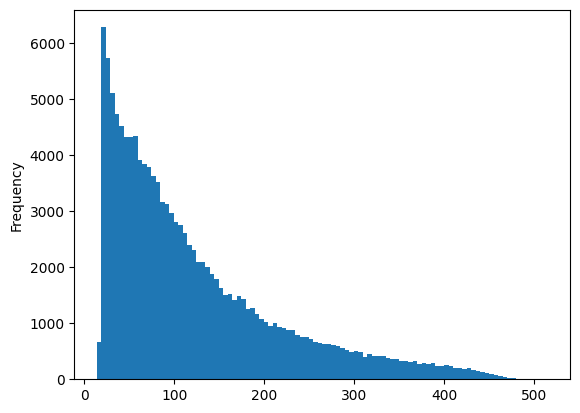

In [67]:
lengths.plot.hist(bins=100)

In [68]:
train_data["lengths"] = lengths

In [69]:
train_data = train_data[train_data["lengths"] < 1000].reset_index(drop=True)

In [70]:
train_data = train_data[
    (1000 > train_data["lengths"]) & (train_data["lengths"] > 10)
].reset_index(drop=True)

In [71]:
train_data.to_csv("../data/final_train_data.csv")

# Prepare vectors

### Load data

In [72]:
DATA_PATH = "../data/final_train_data.csv"
train_data = pd.read_csv(DATA_PATH, index_col=0)

## TfIDFVectors

We will use the TFIDF vectorizer as a simple encoder (note: it's not a real transformer) to feed arrays into the KMeans model.

The Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is a statistical tool utilized in natural language processing and information retrieval to assess the significance of a word within a document relative to a larger set of documents, known as a corpus. It is often used to convert text data into numerical vectors that can serve as input for machine learning models.

How does it work? We need to understand two terms:

Term Frequency (TF): How frequently a term appears in a document.

Inverse Document Frequency (IDF): Reduces the significance of words that are common across all documents.
The process is as follows:

The text is broken down into words (tokens), typically converted to lowercase, and common stop words may be removed.
For each term in each document, compute the term frequency.
Compute the IDF value for each term across the entire corpus.
Multiply the TF value by the IDF value for each term, forming a vector for each document.

NOTE: this part of description was used by me also for BBC - week 4 assignment.

In [73]:
nltk.download("stopwords")
word_list = list(stopwords.words("english"))

stop_words = [
    word
    for word in word_list
    if word not in ["not", "no", "i", "my", "but", "my", "myself"]
]
stop_words += [punct for punct in string.punctuation]
vectorizer = CountVectorizer(stop_words=stop_words)
cv_fit = vectorizer.fit_transform(train_data.text_lematized)

words = np.asarray(cv_fit.sum(axis=0))

id2word = {id: word for word, id in vectorizer.vocabulary_.items()}

[nltk_data] Downloading package stopwords to /home/artur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
condition_range = np.logical_and(1000 > words[0], words[0] > 1)

new_stop_words = []
for i in np.argwhere(~condition_range):
    new_stop_words.append(id2word[i[0]])

keep_words = []
for i in np.argwhere(condition_range):
    keep_words.append(id2word[i[0]])

digit_pattern = re.compile("\d+")

keep_words = set([word for word in keep_words if not digit_pattern.search(word)])

len(new_stop_words), len(keep_words)
text_lemmatized = [
    " ".join([word.lower() for word in text.split() if word.lower() in keep_words])
    for text in train_data.text_lematized
]

train_data["text_lematized"] = text_lemmatized

In [75]:
train_data.to_csv("../data/lemmatized_data_final.csv")

# Prepare sampled data

In [76]:
train_data

,Unnamed: 0,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,...,text_lematized,length,sentiment,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
0,0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,...,strain painting olivia heavy bottom foot,463,positive,463,0,0,11,0,2,93
1,1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,...,seuss philip nel testimonial rel rel seuss ult...,1435,positive,1435,1,0,22,0,2,264
2,2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,...,seuss odor seuss geisel influential poet daddy...,1763,positive,1763,2,0,28,0,2,321
3,3,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,...,philip nel seuss icon academic overview seuss ...,1552,positive,1552,0,1,27,0,2,286
4,4,0826414346,Dr. Seuss: American Icon,NaN,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,...,seuss icon philip nel thoughtful deconstructio...,1988,positive,1988,0,0,29,0,2,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128642,128642,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A26ZAM8KFU0GY9,Jim Estill,0/2,4.0,1155081600,How to Thrive,...,collapse jared diamond collapse anthropologist...,524,positive,524,0,0,6,0,2,94
128643,128643,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A3KKUNIFVEAHNC,saskatoonguy,7/14,2.0,1143244800,Intriguing bits of world history plus sky-is-f...,...,consist viking settlement greenland polynesian...,1709,negative,1709,0,1,20,2,0,293
128644,128644,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ALF72BQ4RIEL,Bill Pen Name,4/9,5.0,1137024000,A Must Read for all Thoughtful People,...,scale thoughtful finger sustainable,258,positive,258,0,0,3,0,2,50
128645,128645,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ZS0YNUQ4UAJ2,Susan Norton,4/9,5.0,1107561600,Full of interest,...,inter et succeed litter deepen crisis europe t...,415,positive,415,0,0,6,0,2,79


In [77]:
train_data.groupby(["sentiment"]).count()

,Unnamed: 0,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,...,cleaned sentences,text_lematized,length,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
sentiment,,,,,,,,,,,,,,,,,,,,,
mixed,10541,10541,10541,1646,8720,8720,10541,10541,10541,10539,...,10541,10541,10541,10541,10541,10541,10541,10541,10541,10541
negative,15338,15338,15338,2285,11765,11765,15338,15338,15338,15337,...,15338,15338,15338,15338,15338,15338,15338,15338,15338,15338
positive,102768,102768,102767,16015,82778,82773,102768,102768,102768,102752,...,102768,102768,102768,102768,102768,102768,102768,102768,102768,102768


### Create input data

Overall, the logic involves below:
- Uniquely identifying and filtering user reviews.
- Preparing datasets for training, testing, and cross-validation ( the latter one is sampled from training dataset).
- Mapping sentiment labels for binary classification.

In [78]:
def get_cv_scores(model):
    ix = best_estimators[model]["scores"]["params"].index(
        best_estimators[model]["best_params"]
    )
    return [
        best_estimators[model]["scores"][f"split{i}_test_score"][ix] for i in range(5)
    ]

In [79]:
unique_reviews = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data["composite_keys"] = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data = train_data[~train_data["sentiment"].isin(["mixed"])]
sampled_data = train_data[train_data["composite_keys"].isin(unique_reviews.unique())]

train_items, test_items = train_test_split(
    train_data, test_size=0.2, stratify=train_data["mapped_sentiment"]
)
cv_items = train_items.sample(frac=0.05)

negative_items = train_items[train_items["mapped_sentiment"] == 0].sample(
    n=4139, replace=True
)

cv_items = pd.concat([cv_items, negative_items])
cv_y = cv_items["mapped_sentiment"].apply(lambda x: 1 if x == 2 else 0)

# Hyperparameter search - phase I

I will use 5 different models for benchmark:
1. **XGB (Extreme Gradient Boosting)**: Uses boosting with decision trees; excels with large datasets, handles missing values well.
2. **Logistic Regression**: Linear model; good for simple, linearly separable data; interpretable but less powerful on complex data.
3. **KNN (K-Nearest Neighbors)**: Instance-based; makes predictions based on the closest data points; effective for small datasets but slow with large ones.
4. **AdaBoost**: Ensemble method using weak learners (e.g., decision stumps); improves performance by focusing on misclassified instances.
5. **Random Forest (RF)**: Ensemble of decision trees; reduces overfitting and improves accuracy through bagging.

I will go into more details when best model will be selected

In [80]:
RESULTS = {}

In [81]:
def create_param_grids():
    param_grids = {
        "xgb": {
            "learning_rate": [0.01, 0.1, 0.2, 0.02],
            "n_estimators": [100, 200, 300, 400, 500, 600, 700],
            "max_depth": [3, 5, 7],
            "colsample_bytree": [0.3, 0.7],
        },
        "log_reg": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs", "liblinear"],
        },
        "knn": {
            "n_neighbors": [2],
            "weights": ["uniform", "distance"],
        },
        "ada": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 1],
        },
        "rf": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
        },
    }
    return param_grids


def create_models():
    models = {
        "xgb": xgb.XGBClassifier(),
        "log_reg": LogisticRegression(n_jobs=5),
        "knn": KNeighborsClassifier(n_jobs=-1),
        "ada": AdaBoostClassifier(),
        "rf": RandomForestClassifier(n_jobs=-1),
    }
    return models


def search_best_params(vectors, cv, models, param_grids):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Performing Grid Search for {model_name}...")
        grid_search = GridSearchCV(
            model, param_grids[model_name], scoring="roc_auc", cv=cv, n_jobs=-1
        )
        grid_search.fit(vectors, cv_y)
        best_estimators[model_name] = {}
        best_estimators[model_name]["model"] = grid_search.best_estimator_
        best_estimators[model_name]["roc_auc_score"] = grid_search.best_score_
        best_estimators[model_name]["scores"] = grid_search.cv_results_
        best_estimators[model_name]["best_params"] = grid_search.best_params_

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best ROC/AUC Score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators


def run_experiment_for_different_tfidf_settings(settings):
    vectorizer = TfidfVectorizer(stop_words=stop_words + new_stop_words, **settings)
    vectors = vectorizer.fit_transform(cv_items["text_lematized"])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    models = create_models()
    param_grids = create_param_grids()
    best_estimators = search_best_params(vectors, cv, models, param_grids)
    return best_estimators

In [82]:
for max_features in [1000, 5000, 10000]:
    best_estimators = run_experiment_for_different_tfidf_settings(
        dict(max_features=max_features)
    )
    RESULTS[max_features] = best_estimators

Performing Grid Search for xgb...
Best parameters for xgb: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 700}
Best ROC/AUC Score for xgb: 0.77805378387603

Performing Grid Search for log_reg...
Best parameters for log_reg: {'C': 0.1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.7752089506245461

Performing Grid Search for knn...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for knn: {'n_neighbors': 2, 'weights': 'distance'}
Best ROC/AUC Score for knn: 0.6491890454254691

Performing Grid Search for ada...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/r

Best parameters for ada: {'learning_rate': 1, 'n_estimators': 150}
Best ROC/AUC Score for ada: 0.7206863881380647

Performing Grid Search for rf...
Best parameters for rf: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC/AUC Score for rf: 0.7821133878135925

Performing Grid Search for xgb...
Best parameters for xgb: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 700}
Best ROC/AUC Score for xgb: 0.8093578400039835

Performing Grid Search for log_reg...
Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8275751444559253

Performing Grid Search for knn...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for knn: {'n_neighbors': 2, 'weights': 'distance'}
Best ROC/AUC Score for knn: 0.6488158440594688

Performing Grid Search for ada...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/r

Best parameters for ada: {'learning_rate': 1, 'n_estimators': 150}
Best ROC/AUC Score for ada: 0.7152127205794974

Performing Grid Search for rf...
Best parameters for rf: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC/AUC Score for rf: 0.8269987752099979

Performing Grid Search for xgb...
Best parameters for xgb: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 700}
Best ROC/AUC Score for xgb: 0.8064817265972837

Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8349229061885135

Performing Grid Search for knn...
Best parameters for knn: {'n_neighbors': 2, 'weights': 'distance'}
Best ROC/AUC Score for knn: 0.6432461261119133

Performing Grid Search for ada...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/veracrypt4/r

Best parameters for ada: {'learning_rate': 1, 'n_estimators': 150}
Best ROC/AUC Score for ada: 0.7113758853427604

Performing Grid Search for rf...
Best parameters for rf: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC/AUC Score for rf: 0.8324518369129679



In [83]:
display_results = {}

In [84]:
def get_cv_scores(best_estimators, model):
    ix = best_estimators[model]["scores"]["params"].index(
        best_estimators[model]["best_params"]
    )
    return [
        best_estimators[model]["scores"][f"split{i}_test_score"][ix] for i in range(5)
    ]

In [85]:
for tf_idf in RESULTS:
    for model in RESULTS[tf_idf]:
        display_results[str(tf_idf) + "_" + model] = get_cv_scores(
            RESULTS[tf_idf], model
        )

The boxplot shown illustrates the range of ROC/AUC scores for each model and the chosen variables. It's clear that Logistic Regression attains the highest score. Moving forward, we'll test by increasing the `max_features` parameter. The next best performer is the Random Forest model, which shows a narrow distribution of scores—indicating consistency—but it still falls short of the best score achieved by Logistic Regression.

In [86]:
mean_scores = {}
for key, value in display_results.items():
    if int(key.split("_")[0]) > 10000:
        continue
    mean_scores[key] = np.mean(value)

mean_scores

pd.DataFrame.from_dict(mean_scores, orient='index', columns=['mean auc score']).sort_values('mean auc score', ascending=False)

,mean auc score
10000_log_reg,0.834923
10000_rf,0.832452
5000_log_reg,0.827575
5000_rf,0.826999
5000_xgb,0.809358
10000_xgb,0.806482
1000_rf,0.782113
1000_xgb,0.778054
1000_log_reg,0.775209
1000_ada,0.720686


08-15 14:58 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
08-15 14:58 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
08-15 14:58 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
08-15 14:58 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/media/veracrypt4/repos/intro-to-supervised-algorithms-in-ma

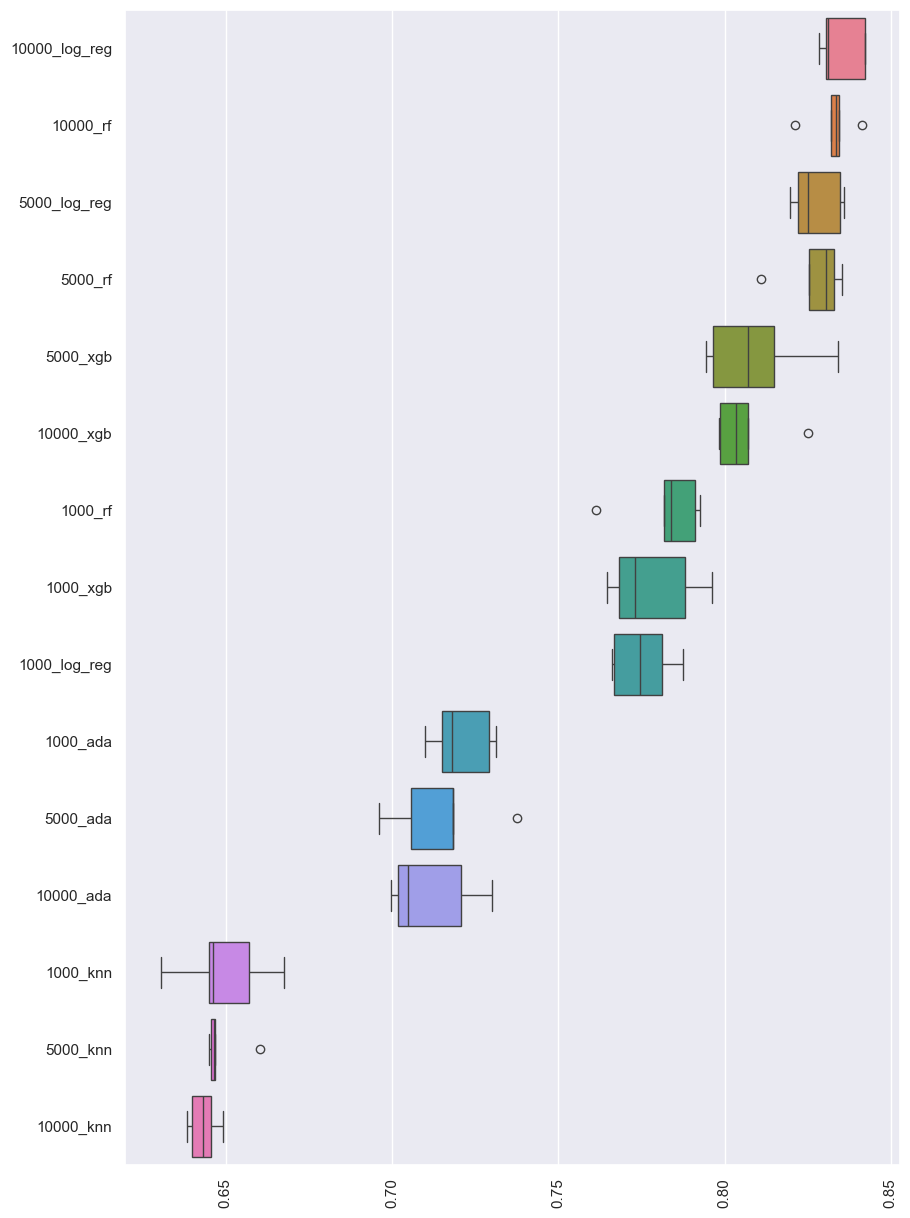

In [87]:
display_results = {}
for tf_idf in RESULTS:
    for model in RESULTS[tf_idf]:
        if int(tf_idf) > 10000:
            continue
        display_results[str(tf_idf) + "_" + model] = get_cv_scores(
            RESULTS[tf_idf], model
        )

means = {k: sum(v) / len(v) for k, v in display_results.items()}
sorted_keys = sorted(display_results, key=lambda x: means[x], reverse=True)
sorted_display_results = {k: display_results[k] for k in sorted_keys}
sns.set(rc={"figure.figsize": (10, 15)})
sns.boxplot(data=sorted_display_results, orient="h")
plt.xticks(rotation=90)
plt.show()

In [88]:
mean_scores = {}
for key, value in display_results.items():
    mean_scores[key] = np.mean(value)


pd.DataFrame.from_dict(mean_scores, orient='index', columns=['mean auc score']).sort_values('mean auc score', ascending=False)

,mean auc score
10000_log_reg,0.834923
10000_rf,0.832452
5000_log_reg,0.827575
5000_rf,0.826999
5000_xgb,0.809358
10000_xgb,0.806482
1000_rf,0.782113
1000_xgb,0.778054
1000_log_reg,0.775209
1000_ada,0.720686


# Hyperparameter search - phase II

In [89]:
def create_models():
    models = {
        "log_reg": LogisticRegression(n_jobs=5),
    }
    return models

In [90]:
for max_features in range(11000, 35000, 2000):
    print("max features", max_features)
    best_estimators = run_experiment_for_different_tfidf_settings(
        dict(max_features=max_features)
    )
    RESULTS[max_features] = best_estimators

max features 11000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8357496599602456

max features 13000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8370881884505664

max features 15000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8379838467647229

max features 17000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8384153492486183

max features 19000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8387315454581229

max features 21000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8394094019981868

max features 23000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423

max features 25000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423

max features 27000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423

max features 29000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423

max features 31000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423

max features 33000
Performing Grid Search for log_reg...


/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_mode

Best parameters for log_reg: {'C': 1, 'solver': 'liblinear'}
Best ROC/AUC Score for log_reg: 0.8397708157318423



/media/veracrypt4/repos/intro-to-supervised-algorithms-in-machine-learning-final-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(


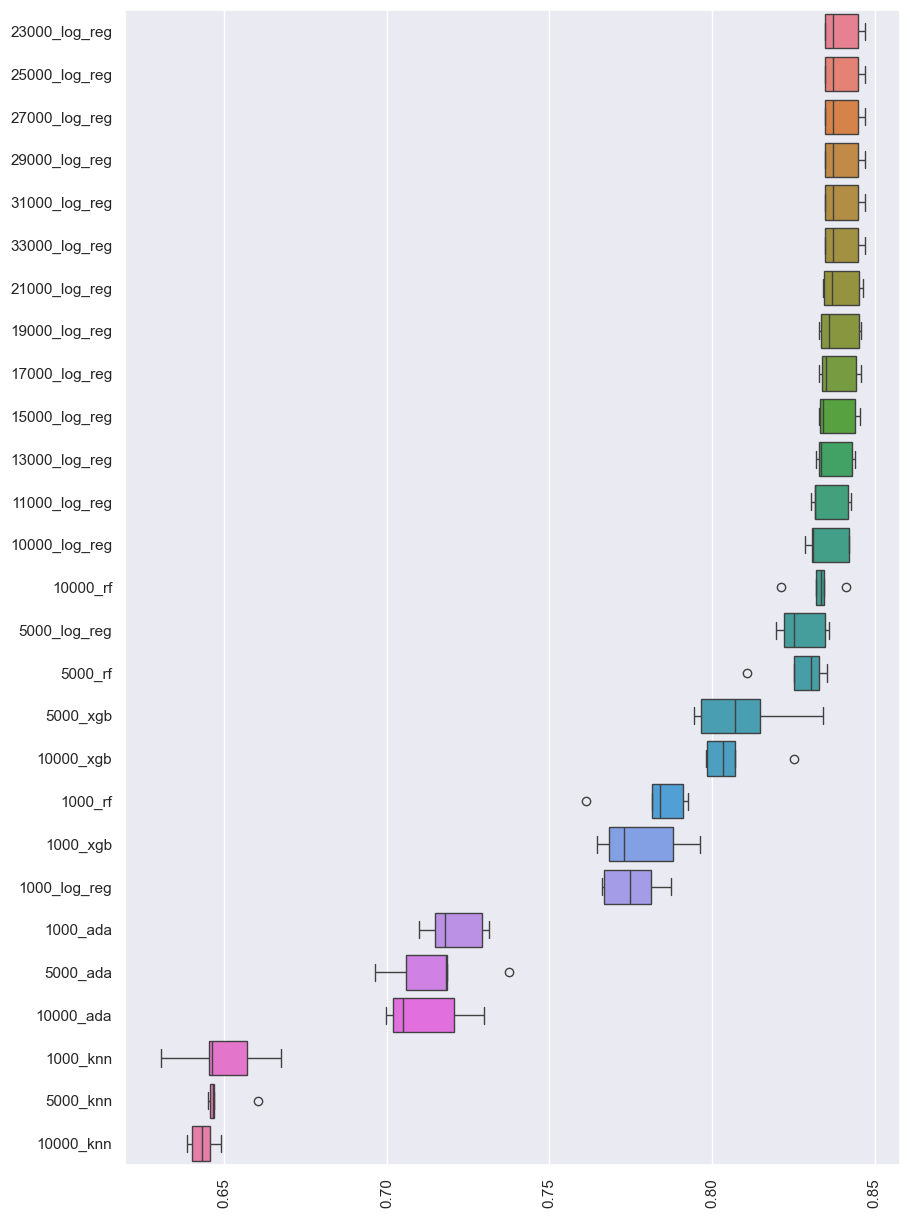

In [91]:
display_results = {}
for tf_idf in RESULTS:
    for model in RESULTS[tf_idf]:
        display_results[str(tf_idf) + "_" + model] = get_cv_scores(
            RESULTS[tf_idf], model
        )

means = {k: sum(v) / len(v) for k, v in display_results.items()}
sorted_keys = sorted(display_results, key=lambda x: means[x], reverse=True)
sorted_display_results = {k: display_results[k] for k in sorted_keys}
sns.set(rc={"figure.figsize": (10, 15)})
sns.boxplot(data=sorted_display_results, orient="h")
plt.xticks(rotation=90)
plt.show()

In [92]:
mean_scores = {}
for key, value in display_results.items():
    mean_scores[key] = np.mean(value)

mean_scores

pd.DataFrame.from_dict(mean_scores, orient='index', columns=['mean auc score']).sort_values('mean auc score', ascending=False)

,mean auc score
33000_log_reg,0.839771
25000_log_reg,0.839771
31000_log_reg,0.839771
29000_log_reg,0.839771
23000_log_reg,0.839771
27000_log_reg,0.839771
21000_log_reg,0.839409
19000_log_reg,0.838732
17000_log_reg,0.838415
15000_log_reg,0.837984


The distribution improved for values greater than 10,000. Let's conclude with 23,000 features, as it achieved the same performance as models with a larger number of features.

# Final model

Logistic regression is a statistical method for binary classification that estimates the likelihood of an outcome based on one or more predictor variables. It uses the logistic function to model a binary dependent variable. In scikit-learn, the `solver` parameter specifies the optimization algorithm, such as 'liblinear', 'saga', or 'lbfgs'. The `C` parameter represents the inverse of regularization strength, with a smaller value indicating stronger regularization to avoid overfitting. The 'liblinear' solver is efficient for small datasets and supports both L1 and L2 regularization, utilizing a coordinate descent algorithm designed for logistic regression.

Liblinear is excellent also for large scale datasets: 
> LIBLINEAR is the winner of the ICML 2008 large-scale learning challenge. It applies automatic parameter selection (a.k.a L1 Regularization) and it’s recommended when you have high dimension dataset (recommended for solving large-scale classification problems)

Source: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

In [93]:
RESULTS[23000]["log_reg"]["best_params"]

{'C': 1, 'solver': 'liblinear'}

In [94]:
from sklearn.metrics import confusion_matrix

In [95]:
vectorizer = TfidfVectorizer(stop_words=stop_words + new_stop_words, max_features=23000)
vectors = vectorizer.fit_transform(train_items["text_lematized"])
print("start svd")
y_train = train_items["mapped_sentiment"].apply(lambda x: 1 if x == 2 else 0)
model = LogisticRegression(**RESULTS[23000]["log_reg"]["best_params"])
model.fit(vectors, y_train)
y_pred_train = model.predict(vectors)
confusion_matrix(y_train, y_pred_train), f1_score(y_train, y_pred_train)

start svd


(array([[ 4014,  8256],
        [  516, 81698]]),
 0.9490497653454765)

In [96]:
test_vectors = vectorizer.transform(test_items["text_lematized"])
# test_vectors = svd.transform(test_vectors)
y_test = test_items["mapped_sentiment"].apply(lambda x: 1 if x == 2 else 0)
y_hat = model.predict(test_vectors)
confusion_matrix(y_test, y_hat), f1_score(y_test, y_hat)

(array([[  854,  2214],
        [  198, 20356]]),
 0.9440682682496986)

In [98]:
import sklearn.metrics  as metrics

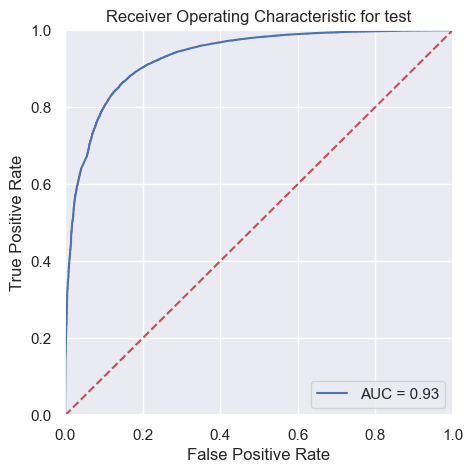

In [99]:
probs = model.predict_proba(vectors)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
sns.set(rc={"figure.figsize": (5, 5)})
plt.title("Receiver Operating Characteristic for test")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

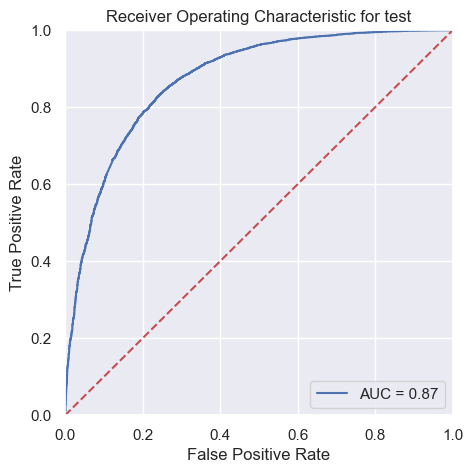

In [100]:
probs = model.predict_proba(test_vectors)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
sns.set(rc={"figure.figsize": (5, 5)})
plt.title("Receiver Operating Characteristic for test")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [101]:
RESULTS[23000]["log_reg"]["best_params"]

{'C': 1, 'solver': 'liblinear'}

The best model was Logistic Regression with the following parameters: {'C': 1, 'solver': 'liblinear'}. It achieved an F1 score of 0.94 and an AUC of 0.86 on the test set. A comparison of F1 scores indicates slight overfitting, as the model achieved an F1 score of 0.95 on the training set. However, the AUC score does not suggest severe overfitting. Further improvements are discussed in the Discussion and Conclusion section.

# Discussion and Conclusion

Training and validation metrics was `roc.auc score` due to the fact that we would like to increase probability of chosing imbalanced labels like 'negative' and 'mixed'. 

On the validation set selected from training data, f1_score was about 0.89, the classificator perform good at targeting `positive` example, however it should be optimized against indication of `negative`  example. 

The selected model was LR model because of pretty good behaviour during cross validation and my decision of using CPU. Probably better result can be achieved:
* via transformers
* better preprocessing of data (keeping some NERs)
* clustering documents and apply separate model for each bucket/cluster
* longer training and longer hyperparameter optimization 
* manipulating threshold of probability indicated in model

# Source

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://stats.stackexchange.com/questions/389865/how-to-distinguish-overfitting-and-underfitting-from-the-roc-auc-curve